In [1]:
import pandas as pd
import time
import requests
from config import *
from esipy import EsiApp, EsiClient, EsiSecurity, cache
#get the last 12 pages of kills from solar system 30000142 "Misaba"
results = []
for i in range(1,11):
    resp = requests.request(
        'GET', f'https://zkillboard.com/api/solarSystemID/30003563/page/{i}/')
    if resp.status_code == 200:
        data = [{"kid": rec["killmail_id"],**rec["zkb"]}for rec in resp.json()]
        results.extend(data)
    time.sleep(1)

c:\Users\Mothership\Desktop\HermitKrabacus\hkvenv\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:


pd.DataFrame(results).shape


(2000, 11)

In [3]:
f_cache = cache.FileCache(path="./f_cache")
# create the eve app interface
esiapp = EsiApp(cache=f_cache).get_latest_swagger

# init the security object
esisecurity = EsiSecurity(redirect_uri=ESI_CALLBACK,
                          client_id=ESI_CLIENT_ID,
                          secret_key=ESI_SECRET_KEY,
                          headers={'User-Agent': ESI_USER_AGENT})

# init the client
esiclient = EsiClient(security=esisecurity,
                      cache=f_cache,
                      headers={'User-Agent': ESI_USER_AGENT})


ops = [esiapp.op['get_killmails_killmail_id_killmail_hash'](killmail_id=record['kid'],killmail_hash=record['hash']) for record in results]
req_resps = esiclient.multi_request(ops)


<AxesSubplot: xlabel='time'>

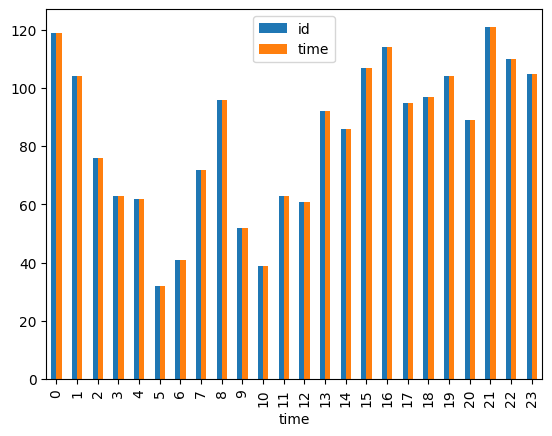

In [4]:
df = pd.DataFrame([{"id": resp.data['killmail_id'],"time": resp.data["killmail_time"].v.time()}for req, resp in req_resps if resp.status == 200])
df.time = pd.to_datetime(df.time.apply(lambda x: x.__str__()[:-3]))
df.groupby(df.time.dt.hour).count().plot(kind='bar')


In [5]:
base_df = pd.DataFrame([{
    "id": resp.data['killmail_id'],
    "time": resp.data["killmail_time"].v
} for req, resp in req_resps if resp.status == 200])
base_df.time = pd.to_datetime(base_df.time.apply(lambda x: x.__str__()))
base_df.time.min(), base_df.time.max()

(Timestamp('2022-10-02 09:07:54+0000', tz='UTC'),
 Timestamp('2022-11-27 01:14:55+0000', tz='UTC'))

<AxesSubplot: xlabel='weekday'>

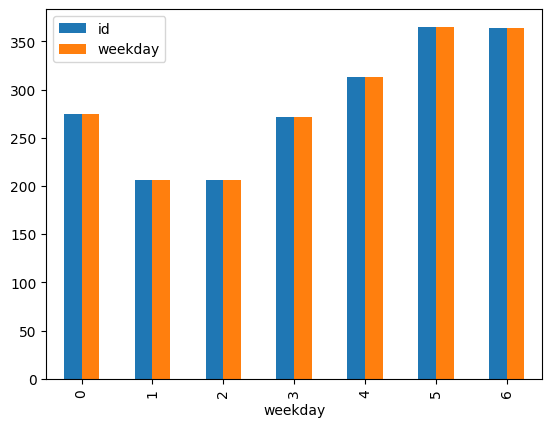

In [6]:
df = pd.DataFrame([{
    "id": resp.data['killmail_id'],
    "weekday": resp.data["killmail_time"].v
} for req, resp in req_resps if resp.status == 200])
df.weekday = pd.to_datetime(df.weekday.apply(lambda x: x.__str__()))
df.groupby([df.weekday.dt.weekday]).count().plot(kind='bar')


In [7]:
import datetime as dt

date_frame = pd.date_range(start=dt.datetime(year=base_df.time.min().year,
                                month=base_df.time.min().month,
                                day=base_df.time.min().day,
                                hour=base_df.time.min().hour),
              end=dt.datetime(year=base_df.time.max().year,
                              month=base_df.time.max().month,
                              day=base_df.time.max().day,
                              hour=base_df.time.max().hour),
              freq='H').to_frame().reset_index(drop=True)

date_frame.columns = ['time']
base_df['base_time'] = base_df.time.apply(lambda x: dt.datetime(year = x.year, month = x.month, day = x.day, hour = x.hour))
base_df = base_df.groupby(base_df.base_time).agg({'id': 'count'}).reset_index()
res_df = pd.merge(date_frame, base_df, how='left', left_on='time', right_on='base_time').fillna(0)
res_df.drop('base_time', axis=1, inplace=True)

<AxesSubplot: xlabel='time'>

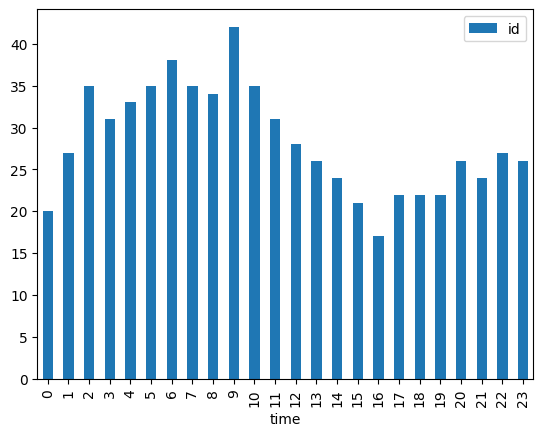

In [8]:
test = res_df
test[test.id ==1]
res_df[(res_df.id == 0)].groupby([res_df.time.dt.hour]).agg({"id": "count"}).plot(kind='bar')


<AxesSubplot: xlabel='time'>

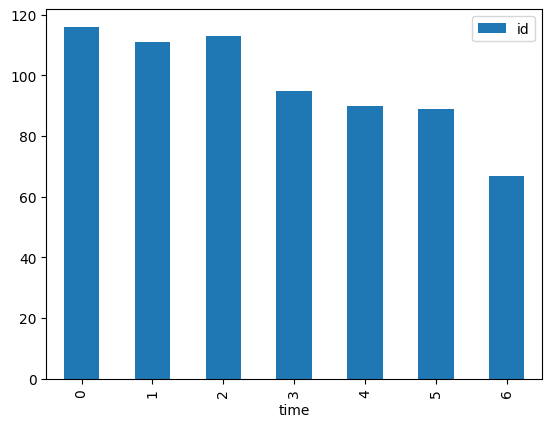

In [9]:
res_df[(res_df.id == 0)].groupby([res_df.time.dt.weekday]).agg({
    "id": "count"
}).plot(kind='bar')


In [10]:
res_df[(res_df.id == 0) & (res_df.time.dt.hour == 9)]


,time,id
24,2022-10-03 09:00:00,0.0
48,2022-10-04 09:00:00,0.0
96,2022-10-06 09:00:00,0.0
168,2022-10-09 09:00:00,0.0
192,2022-10-10 09:00:00,0.0
216,2022-10-11 09:00:00,0.0
240,2022-10-12 09:00:00,0.0
288,2022-10-14 09:00:00,0.0
312,2022-10-15 09:00:00,0.0
336,2022-10-16 09:00:00,0.0
